## Deep Learning Approaches for RF-based detection & classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from Torch_Models import *

# from torchsummary import summary

### Load Features

In [2]:
feat_folder = '../Features/'
feat_name = 'SPEC'
seg_len = 20
n_per_seg = 1024
interferences = ['WIFI','CLEAN','BLUE','BOTH']
output_name = 'drones'
feat_format = 'IMG'

dataset = DroneDetectTorch(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
                                output_name, interferences)

# dataset = load_dronedetect_data(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
#                                 output_name, interferences)

Directory Name:  ../Features/IMG_SPEC_1024_20/


In [3]:
print('dataset size', len(dataset))
print('shape of each item', dataset.__getitem__(12)[0].shape)

dataset size 36778
shape of each item torch.Size([224, 224, 3])


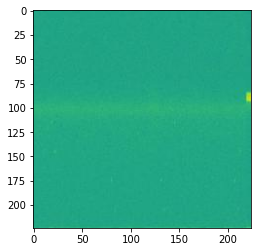

In [4]:
d = dataset.__getitem__(4)[0]
plt.imshow(d)
plt.show()

## VGG16 Features

In [45]:
vgg16 = models.vgg16()
# summary(vgg16, (3,224,224))

modules=list(vgg16.children())[:-1]
vggmodel=nn.Sequential(*modules)

for p in vggmodel.parameters():
    p.requires_grad = False

In [46]:
# test one input
d = dataset.__getitem__(0)
inarr = d[0]
inarr = torch.moveaxis(inarr, 2, 0)
# print(inarr.shape)
# postmove = inarr[0]
# print(premove==postmove) # confirm it is the same channel

# WHEN using single channel array format
# inputr = inarr.repeat(1,3,1,1)
# inputr = inputr.to(device)
out = vggmodel(inarr)

# reshape the output
out.flatten()

tensor([0.0000, 0.0196, 0.0182,  ..., 0.0562, 0.0534, 0.0152])

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vggmodel = vggmodel.to(device) #set model to device

Vgg_Feats = []
Vgg_y_num = [] # numerical values for y
for n in tqdm(range(len(dataset))):
    d = dataset.__getitem__(n)
    inarr = d[0]
#     inputr = inarr.repeat(1,3,1,1)  # repeat to have 3 channels of the same info
    inputr = torch.moveaxis(inarr, 2, 0) # move axis to have channels come first
    inputr = inputr.to(device)
    out = vggmodel(inputr)
    
    Vgg_Feats.append(out.cpu().numpy().flatten())
    Vgg_y_num.append(np.array(d[1]))

Vgg_Feats = np.array(Vgg_Feats)
Vgg_y_num = np.array(Vgg_y_num)

# flatten the middle dimension
Vgg_Feats = Vgg_Feats.reshape(Vgg_Feats.shape[0], Vgg_Feats.shape[-1])
# invert labels back to categorical
# vgg_y_cat = dataset.le.inverse_transform(vgg_y.astype(np.int64))
Vgg_y_cat = np.array([dataset.idx_to_class[i] for i in Vgg_y_num])

100%|███████████████████████████████████████████████████████████████████████████████████| 36778/36778 [02:07<00:00, 288.79it/s]


In [40]:
# Save VGG features
# vgg_save = {'feats': vgg_feats, 'y_cat':vgg_y_cat, 'y':vgg_y}
# file_name = 'transfer_learning_feats/VggFeats_'+str(seg_len)+'_'+str(n_per_seg)+'correct_psd_img'
# np.save(file_name, vgg_save)

## Resnet Features

In [74]:
## Transfer learning from Resnet50 & Apply Logistic Regression (Swinney paper)

# use pretrained resnet feature and just keep up to the last layer
resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [75]:
# test resnet
# input = torch.randn(1,1,30,300)
d = dataset.__getitem__(0)
inarr = d[0]
resnet50(inarr).shape

In [76]:
ResNet_Feats = []
y_num = []
for n in range(len(dataset)):
    d = dataset.__getitem__(n)
    inarr = d[0]
    inputr = torch.moveaxis(inarr, 2, 0) # move axis to have channels come first
    inputr = inputr.to(device)
    
    out = resnet50(inputr)
    ResNet_Feats.append(np.array(out))
    y_num.append(np.array(d[1]))

ResNet_Feats = np.array(ResNet_Feats)
y_num = np.array(y_num)

# flatten the middle dimension
ResNet_Feats = resnet_feats.reshape(ResNet_Feats.shape[0], ResNet_Feats.shape[-1])
# invert labels back to categorical
# y_cat = dataset.le.inverse_transform(y_num.astype(np.int64))
resnet_y_cat = np.array([dataset.idx_to_class[i] for i in ResNet_Feats])

### Run Logistic Regression

In [48]:
Xs_feat = Vgg_Feats # which features to use for logit reg
y_cat = Vgg_y_cat
print('Shape of Input Features: (n sample x n feats):', Xs_feat.shape)

Shape of Input Features: (n sample x n feats): (36778, 25088)


In [53]:
# split data into K-fold
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# model parameters
Cs=list(map(lambda x:pow(10,x),range(-2,2,1)))
print('Cs:', Cs)

best_params_ls = []
acc_ls = []
f1_ls = []
runt_ls = []

parameters = {'C':Cs}

for train_ix, test_ix in tqdm(cv.split(Xs_feat)):
    
    # find the optimal hypber parameters
    lr = LogisticRegression(solver='saga')
#     clf = GridSearchCV(lr, parameters, n_jobs=1) # gridsearch cv
    clf = LogisticRegression(C =1.0, max_iter=5000, class_weight = 'balanced',n_jobs=1) # fixed parameter
    
    scaler = preprocessing.StandardScaler().fit(Xs_feat[train_ix])
    X_train_scale = scaler.transform(Xs_feat[train_ix])
    
    clf.fit(X_train_scale, y_cat[train_ix])
    
#     print(clf.best_params_)
#     best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    X_test_scale = scaler.transform(Xs_feat[test_ix])
    y_pred, runtimes = atomic_benchmark_estimator(clf, X_test_scale, output_type= '<U3', 
                                                  verbose=False)
    runt_ls.append(np.mean(runtimes))
    
    acc = accuracy_score(y_cat[test_ix], y_pred)
    f1 = f1_score(y_cat[test_ix], y_pred, average='weighted')
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    acc_ls.append(acc)
    f1_ls.append(f1)
    
out_msg = 'Net+LR: average test acc: {:.2}, F1: {:.2}, Run-time: {:.2}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
print(out_msg)

Cs: [0.01, 0.1, 1, 10]


0it [1:01:27, ?it/s]


KeyboardInterrupt: 

In [ ]:
y_cat

## Run kNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
## Fixed parameter kNN
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=10, shuffle=True)

# Ns=list(range(2,100,20))
# Ns = [100]
parameters = {'n_neighbors':Ns}
print('list of neighbours:', Ns)

Xs_arr = Vgg_Feats
y_arr = Vgg_y_cat

best_params_ls = []
score_ls = []
f1_ls = []

for train_ix, test_ix in cv.split(Xs_arr):
    # scale data
    scaler = preprocessing.StandardScaler().fit(Xs_arr[train_ix])
    X_train_scale = scaler.transform(Xs_arr[train_ix])
    
    # find the optimal hypber parameters
    clf = KNeighborsClassifier(n_neighbors=5)
#     clf = GridSearchCV(neigh, parameters, n_jobs=1)
    clf.fit(X_train_scale, y_arr[train_ix])
#     print(clf.best_parameters)
    
    # predict on the test data
    X_test_scale = scaler.transform(Xs_arr[test_ix])
#     y_pred = clf.predict(X_test_scale)
    y_pred, runtimes = atomic_benchmark_estimator(clf, X_test_scale, output_type= '<U3', 
                                                  verbose=False)
    acc = accuracy_score(y_arr[test_ix], y_pred)
    f1 = f1_score(y_arr[test_ix], y_pred, average='weighted')
    f1_ls.append(f1)
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    score_ls.append(acc)
    
print('VGG feats+kNN K-fold average test score:', np.mean(score_ls))
print('VGG feats+kNN K-fold average test F1:', np.mean(f1_ls))

list of neighbours: [100]


## Fully Connected Layer

In [100]:
# Model in Torch_Models
# class VGGFC(nn.Module):
#     def __init__(self, num_classes):
#         super(VGGFC,self).__init__()
#         self.num_classes = num_classes
#         self.vggfull = models.vgg16(pretrained=True)
#         modules=list(self.vggfull.children())[:-1] # remove the fully connected layer & adaptive averaging
#         self.vggfeats=nn.Sequential(*modules)
        
#         for param in self.vggfeats.parameters():
#             param.requires_grad_(False)
        
#         self._fc = nn.Linear(25088, num_classes)
#     def forward(self, x):
#         if len(x.shape)==4:
#             x = torch.moveaxis(x,-1, 1)
#         else:
#             x = torch.moveaxis(x, -1, 0)
#         x = self.vggfeats(x)
# #         print(x.shape)
#         x = x.reshape(-1,25088)
#         x = self._fc(x)
        
#         return x

In [5]:
class ResNetFC(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFC,self).__init__()
        self.num_classes = num_classes
        self.resnetfull = models.resnet50(pretrained=True)
        modules=list(self.resnetfull.children())[:-2] # remove the fully connected layer & adaptive averaging
        self.resnetfeats=nn.Sequential(*modules)
        
        for param in self.resnetfeats.parameters():
            param.requires_grad_(False)
        
        self._fc = nn.Linear(100352, num_classes)
    def forward(self, x):
        if len(x.shape)==4:
            x = torch.moveaxis(x,-1, 1)
        else:
            x = torch.moveaxis(x, -1, 0)
        x = self.resnetfeats(x)
        x = x.reshape(-1,100352)
        x = self._fc(x)
        
        return x

### Kfold CV

In [6]:
from nn_functions import runkfoldcv

In [10]:
# Configuration options
k_folds = 5

batch_size = 128 # 128
num_classes = 7
learning_rate = 0.01
num_epochs = 10 # 0
momentum = 0.95
l2reg = 1e-4

Model = ResNetFC(num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
trainedModel, res_acc, res_f1, res_runtime = runkfoldcv(Model, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
    Loss after mini-batch    50: 1.20664
    Loss after mini-batch   100: 0.71691
    Loss after mini-batch   150: 0.67675
    Loss after mini-batch   200: 0.61673
Starting epoch 2
    Loss after mini-batch    50: 0.47226
    Loss after mini-batch   100: 0.48773
    Loss after mini-batch   150: 0.47424
    Loss after mini-batch   200: 0.46832
Starting epoch 3
    Loss after mini-batch    50: 0.36101
    Loss after mini-batch   100: 0.36679
    Loss after mini-batch   150: 0.40254
    Loss after mini-batch   200: 0.36075
Starting epoch 4
    Loss after mini-batch    50: 0.29463
    Loss after mini-batch   100: 0.32518
    Loss after mini-batch   150: 0.34393
    Loss after mini-batch   200: 0.30175
Starting epoch 5
    Loss after mini-batch    50: 0.23496
    Loss after mini-batch   100: 0.24725
    Loss after mini-batch   150: 0.28422
    Loss after mini-batch   200: 0.28156
Starting epoch 6
    L

In [ ]:
trainedModel

In [ ]:
res_acc, res_f1, res_runtime

## Save model

In [104]:
# Save model
model_type = 'VGGFC'
model_name = model_type+'_'+str(feat_name)+'_'+str(n_per_seg)+'_'+str(seg_len)
model_path = 'saved_models/'
trainedModel = trainedModel.cpu()
torch.save(trainedModel, model_path+model_name)
print('Model saved as:', model_name)

Model saved as: VGGFC_SPEC_1024_20


In [105]:
### Test reload
# m2 = torch.load(model_path+model_name)
# in2 = dataset.__getitem__(0)[0]
# out = m2(in2)
# _,pred = torch.max(out,1)